#  MOCCA : *MO*mentum *C*alibration in *C*oincidence data *A*nalysis

## Abstract


The aim of this notebook is to calibrate the raw data obtained from coindence spectroscopy using image processing and linear fits. Momentum calibration is very important for proper data analysis as all the properties of the particles like kinetic energies, angles of fragmentation depend on the momentum. The data analysis in my research group is done using the [ANACONDA MATLAB package](https://github.com/gasfas/ANACONDA_2) developed by former students the group. The current version doesn't have any autocalibration of data, so this project is an attempt to make the calibration as automated as possible for faster data analysis. The momentum calibration process involves seven free parameters and they are all used in this notebook. Fine calibration is still done manually in this notebook as the human brain is the best machine to detect patterns and shapes which is essential for fine adjustments. The project various Python 3 packages like Pandas, Numpy, Scipy, Scikit image, matplotlib and ipywidgets. 

## Workflow 

The imported data is text file generated by [ANACONDA MATLAB](https://github.com/gasfas/ANACONDA_2) and it contains has metadata and data. The metadata has details of the spectrometer and calibration factors previously calculated. The experimental data used as input here has 4 columns:

1. X (mm) - The X position of the detected particle on 2D detector
2. Y (mm) - The Y position of the detected particle on 2D detector
3. m2q labels (a.u.) - The mass (m) by charge (q) label of the particle calculated by MATLAB package
4. tof(ns) - The time of flight of the detected particle in the spectrometer

The time of flight and m2q labels are related as,$$ \frac{m}{q} = (\frac{TOF - t0}{factor})^2 $$
The calibration factors 'factor' and 't0' are calculated by MATLAB package  so we import them as metadata.

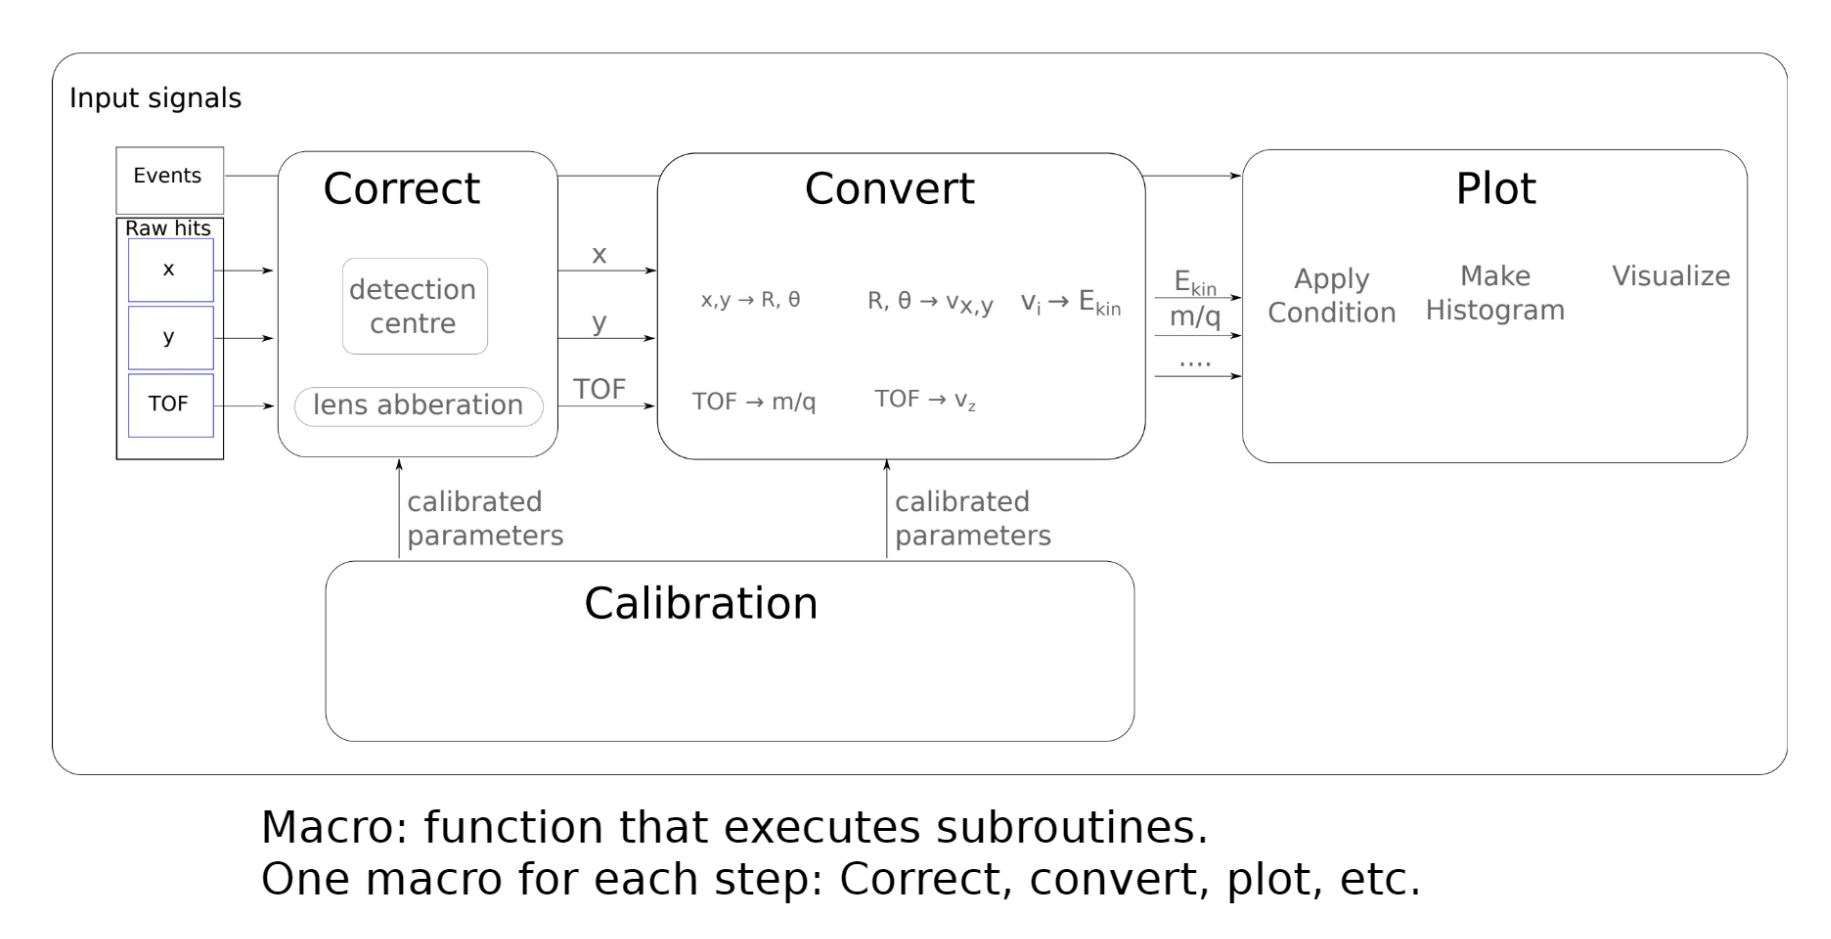
This notebook calculates with the calibration factors to be used in MATLAB package.


## Import packages

In [1]:
from my_code.x0y0_calc import *
from my_code.theta_calib import *
from my_code.tof_no_p import tof_no_p as tof_0
from my_code.electric_field import *
from my_code.p0 import *
from my_code.dp import *
from my_code.rot_axes import *
from my_code.momentum_plot import *
from my_code.momentum_plot2 import *
from my_code.momentum_sphere import *

import pandas as pd
from  matplotlib.pyplot import *
import scipy.io
import numpy as np
from scipy import stats
from ipywidgets import interact, interactive, fixed


## Import data in PANDAS dataframe

In [2]:
file = 'testdata/test_data2.txt' ##filename

In [3]:
data = pd.read_csv(file, delim_whitespace =True, skiprows =8, header =0)
data.dropna(inplace=True) #drop rows that have nan (not m2q labelled)
data 

,x,y,m2q,tof
5,-0.8080,-10.6951,88.0,9000.4960
6,7.2880,8.0738,88.0,9042.7798
13,-10.5359,-7.8641,44.0,6405.6327
14,4.0876,1.2133,88.0,9025.9999
16,16.5405,-23.5473,12.0,3357.5473
...,...,...,...,...
3575052,5.6244,-12.2680,16.0,3860.5371
3575053,-16.7148,-0.3895,12.0,3368.5878
3575054,-3.8975,15.3986,16.0,3818.7396
3575055,24.0503,-15.8031,16.0,3891.6902


### Importing metadata from the text file

In [4]:
myfile = open(file , 'r',encoding="utf8")
mlines = list(myfile.readlines()[2:7])
factor = float(mlines[0].split( )[-1])
tshift = float(mlines[1].split( )[-1])
v1 = float(mlines[2].split( )[-1])
v2 = float(mlines[3].split( )[-1])
dist = float(mlines[4].split( )[-1])
myfile.close()

In [5]:
print(factor) #factor as mention above
print(tshift) #t0 as mentioned above
print(v1, v2, dist) #the voltages on the spectrometer and the distance between electron to ion grid

962.6
13.2
450.0 0.0 0.014


## Define the mass labels you want to calibrate

Specify the mass and charge labels to be used for calibration. The mass labels depends on the sample studied and must be carefully changed for each data file. 

Example of mass and charge labels:

$CO_2^+$ has mass label = 44 and charge label = 1 \
$ NH_3^{3+} $ has mass label = 17 and and charge label = 3

### Note: Specify atleast 5 mass labels for good calibration

The test data provided is for $CO_2$ clusters so we define the mass labels of the expected fragments like $C^+$, $O^+$, $CO_2^{2+}$, $CO^+$, $O_2^+$, $CO_2^+$, $(CO_2)_2^+$, $(CO_2)_3^+$, $(CO_2)_4^+$, ...

In [6]:
# define the m2q labels you are interested in:
m = np.array([12,16,22,28,32,44,88,132,176,220,264,308,352,396])
#c =np.ones(len(m)) # if no multiple charges
c = np.array([1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) #22 has 2+ charge

In [7]:
tof_no_p = tof_0(m,tshift,factor) #an array of The TOF values corresponding to m2q labels if particles had no p
#create mapping input
map_dict1 = { m[i] : c[i] for i in range(len(m)) }
map_dict2 = { m[i] : tof_no_p[i] for i in range(len(m)) }
data['charge'] = data.m2q.map(map_dict1)
data['tof_no_p'] = data.m2q.map(map_dict2)
data.dropna(inplace=True) #drop rows that have nan (not the m2q labels we defined in m)


In [8]:
#Calculate the electric field in spectrometer
ef = electric_field(v1,v2,dist)

## Theta auto-calibration

The theta calibration function rotates the XY coordinates and finds the optimum theta value. The calibration takes time so it is advised to do it once and then use the manual input for further calibration.

### Why calibrate?

It is very difficult to align the detector XY axis to the molecular beam source while doing the experiment. In this step we rotate the original detector image till the XY axis align with the molecular beam (which is fixed to be X direction). The physical center of the detector images is calculated as (X0, Y0). For the optimized theta value the slope of Y0 vs different masses is close to zero.


In [9]:
#### Uncomment if theta calibration is not done ####

#theta = theta_calib(data,m,tof_no_p,10,90,10)
#theta = theta_calib(data,m,tof_no_p,theta-5,theta+5,0.5)
#print('theta=', theta)

#### If already calibrated ####
theta = 45.0
print('theta=', theta)


theta= 45.0


## XY auto-calibration

The physical centers of the detector images are calculated and plotted for all mass labels.

### Why calibrate?

Often the detector images are not centered at zero. Here we calculate values dX and dY to translate the detector image to center of the detector.

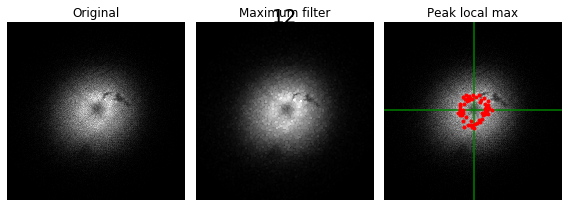

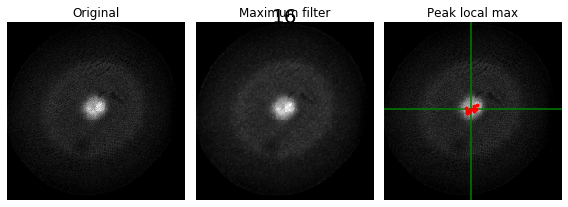

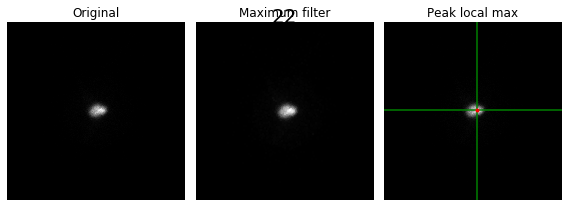

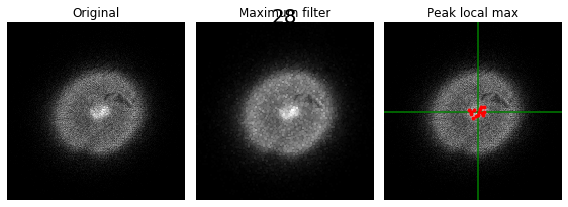

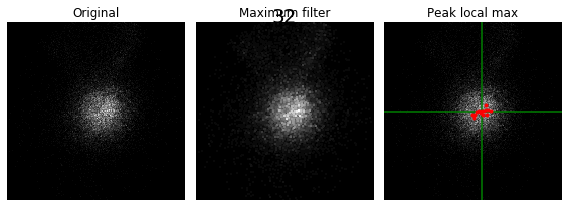

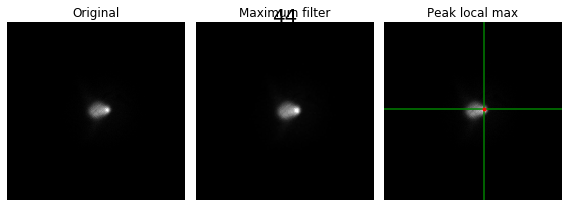

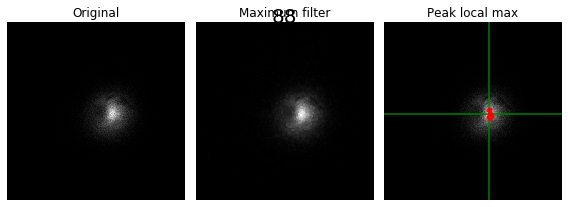

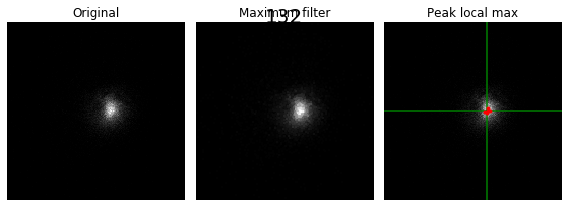

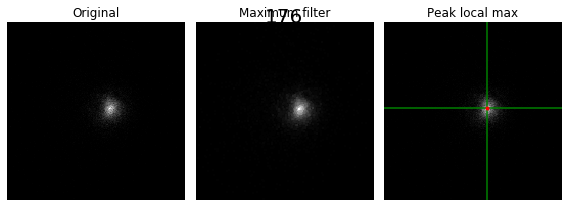

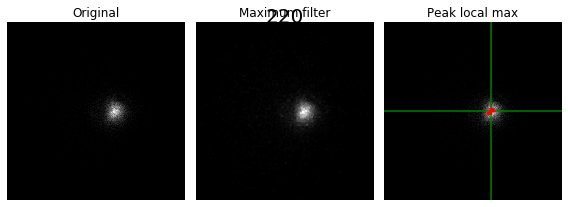

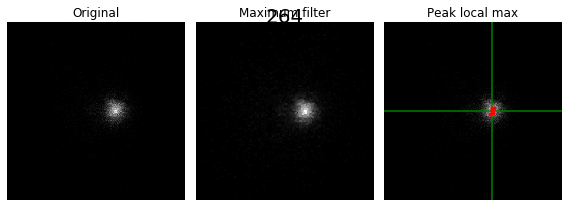

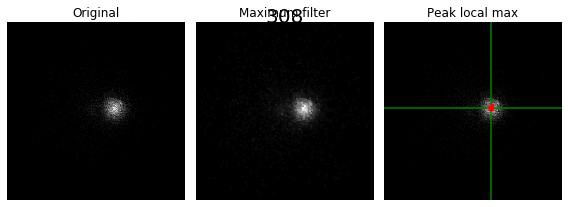

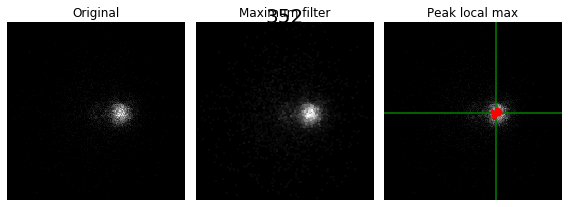

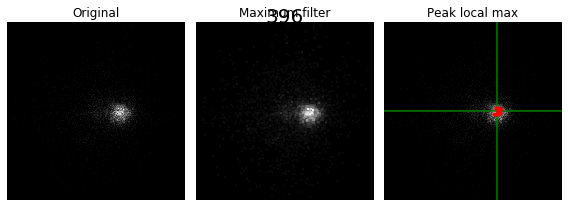

In [10]:
x0, y0 = x0y0_calc(data,m,theta,Graphics = 1) 

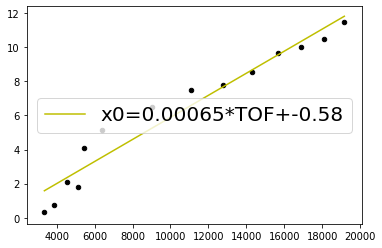

In [11]:
#%% x0 The X coordinates of the physical centers
plt.figure(21)
slopex, interceptx, r_value, p_value, std_err = stats.linregress(tof_no_p,x0)
line = slopex*np.array(tof_no_p)+interceptx
plt.plot(tof_no_p, line, 'y', label='x0={:.5f}*TOF+{:.2f}'.format(slopex,interceptx))
#end
plt.scatter(tof_no_p,x0, color="k", s=20)
plt.legend(fontsize=20)
plt.show()


The slope of the plot gives the velocity of the particles in the molecular beam, the intercept from the plot is the dX value by which the the image must be translated.

In [12]:
#The molecular beam velocity
v_mb =slopex*1e6 ## m/s

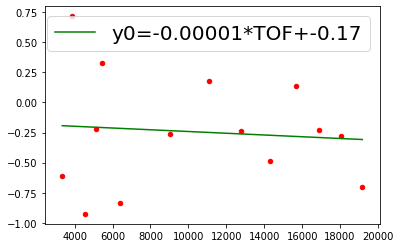

In [13]:
#%% y0 The Y coordinates of the physical centers
plt.figure(22)
slopey, intercepty, r_value, p_value, std_err = stats.linregress(tof_no_p,y0)
line = slopey*np.array(tof_no_p)+intercepty
plt.plot(tof_no_p, line, 'g', label='y0={:.5f}*TOF+{:.2f}'.format(slopey,intercepty))
#end
plt.scatter(tof_no_p,y0, color="r", s=20)
plt.legend(fontsize=20)
plt.show()


The slope of the plot is close to zero because the theta is well calibrated, the intercept from the plot is the dY value by which the the image must be translated.

## Use the calibration factors in raw data

In [14]:
data['x'] , data['y'] = rot_axes(data['x'],data['y'],theta) #the detector image is rotated
data['x'] = data['x'] - interceptx #we translate the image
data['y'] = data['y'] - intercepty #we translate the image

In [15]:
def cart2sper(data):
    data['phi'] = np.arctan2(data['dpy'], data['dpx'])
    data['r'] = np.sqrt(data['dpx']**2 + data['dpy']**2 + data['dpz']**2)
    data['theta'] = np.arccos(data['dpz'] / data['r'])
    return data

## Fine manual calibration 

Now we do fine adjustments in the previously calculated calibration factors. 

The momentum values of the particles are calculated. We calculate momentum components in cartesian and spherical polar coordinates. 
A perfect calibration results in total momentum p_norm of the particle being independent of the momentum components.

An example of good calibration is :


<div>
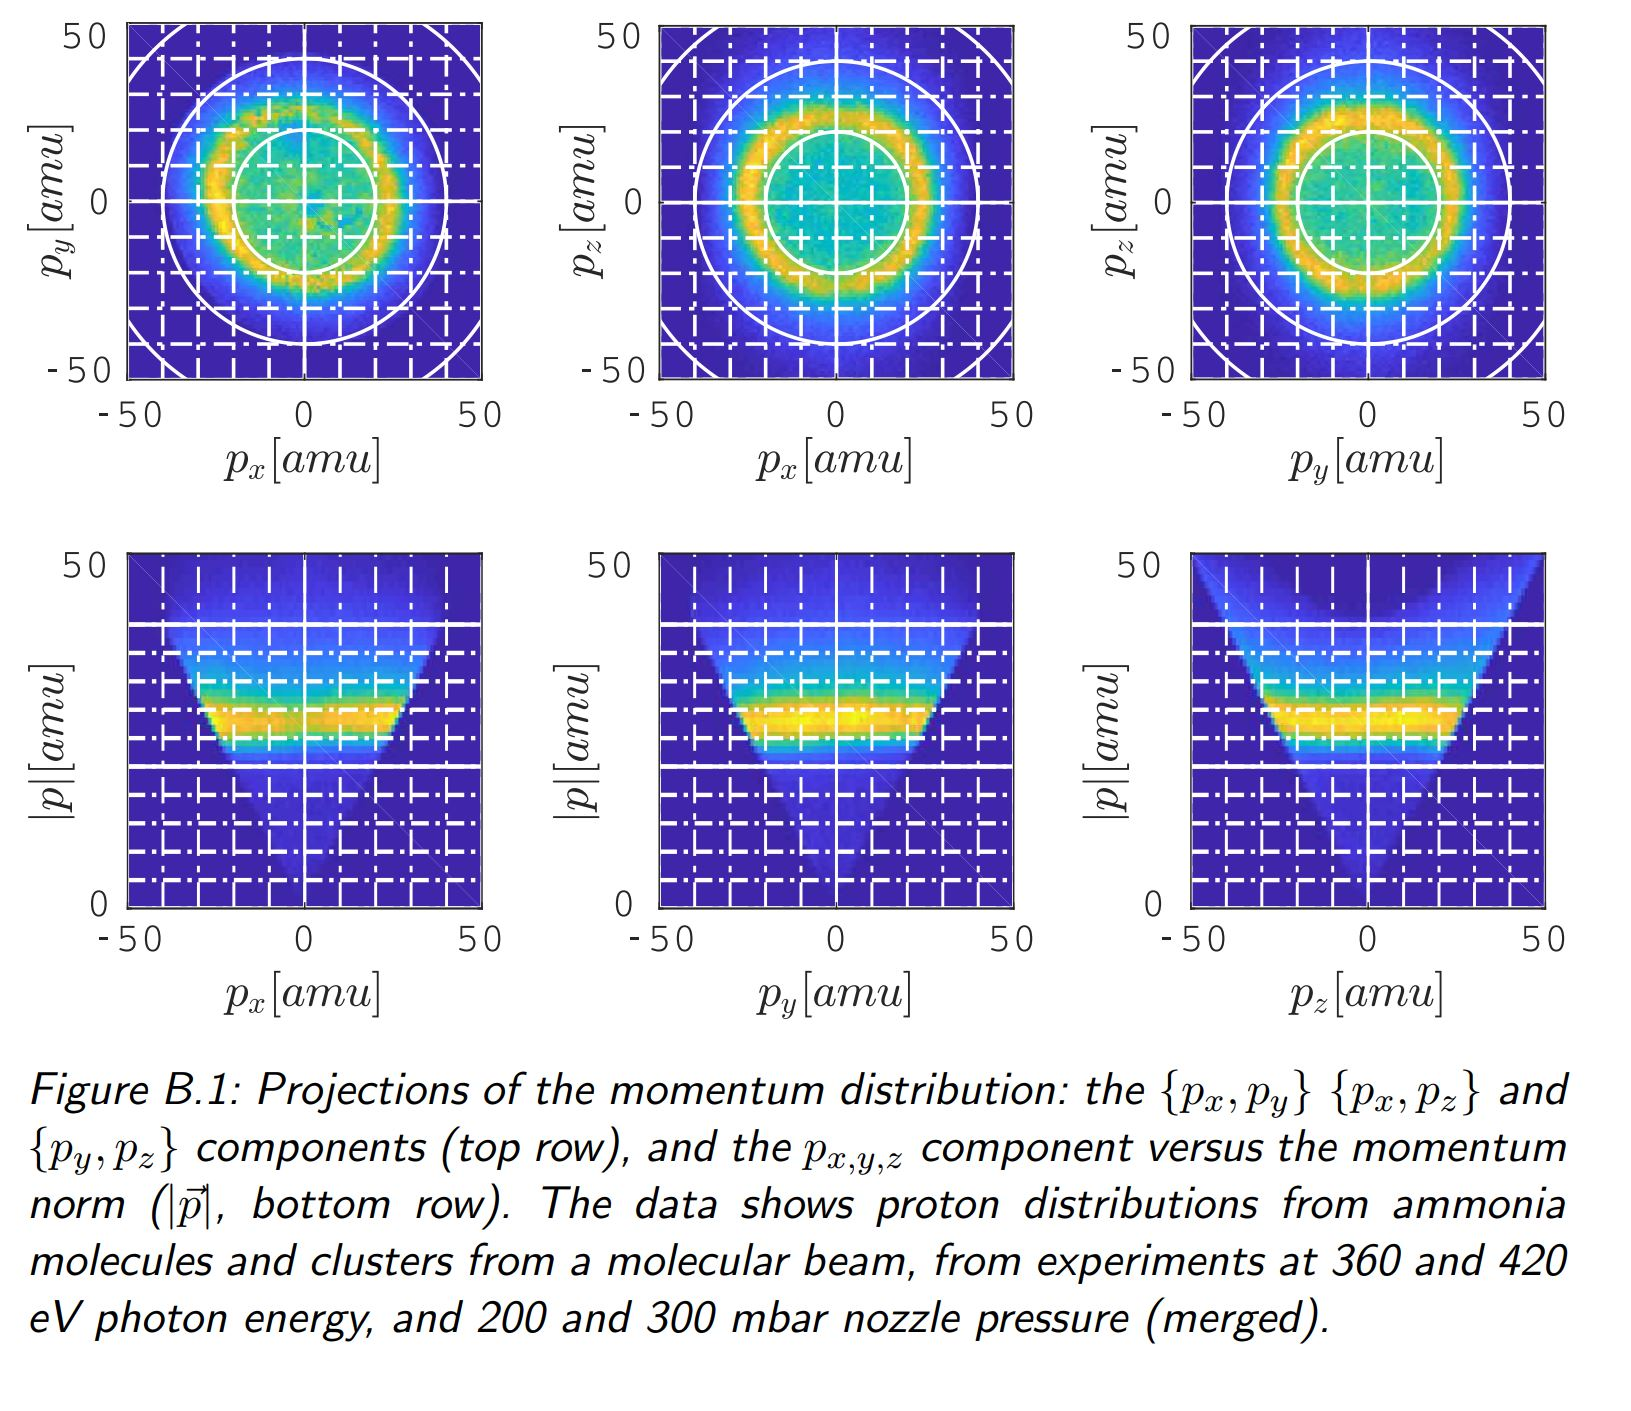
</div>

In [22]:
### select mass label to calibrate ###
mass = 22 #change to value you want plot for calibration


## the default values of function f are the calibration factors i found for this test data
#(df,dx_new= -1.5, dy_new = 0.6, v1 = 390, tshift_new = 1.6,factor_new =0): 28
#(df,dx_new= -0.5, dy_new = 0.2, v1 = 390, tshift_new = 0.25,factor_new =0)>44
def f(df,dx_new= -1.0, dy_new = 0.8, v1 = 390, tshift_new = 0.925,factor_new =0):
    #print(df) 
    strg ='dx_new= {}, dy_new = {}, v1 = {}, tshift_new = {}'.format(dx_new ,dy_new  ,v1,tshift_new) 
    df['x'] = df['x'] - dx_new #we translate the image
    df['y'] = df['y'] - dy_new #we translate the image
    ef = electric_field(v1,v2,dist)
    global tof_no_p
    tof_no_p = tof_0(m,tshift + tshift_new,factor + factor_new)
    map_dict2 = { m[i] : tof_no_p[i] for i in range(len(m)) }
    df['tof_no_p'] = df.m2q.map(map_dict2)
    
    ##plotting
    df = p0(df, m, c, tof_no_p, v_mb, ef)
    df = dp(df, ef)
    df = cart2sper(df)
#    momentum_plot2(df, 'dpx','dpy','dpx','dpz','dpy', 'dpz', strg, mass) #to find tshift   
    momentum_plot2(df, 'dpx','dp_norm','dpy','dp_norm','dpz', 'dp_norm', strg, mass) #to find v1 dx dy

    momentum_sphere(df, 'dp_norm','r','dp_norm','theta','dp_norm', 'phi', strg, mass) #to find v1 dx dy
    #momentum_sphere(df, 'dp_norm','r','dp_norm','theta','dp_norm', 'phi', strg, 44) #to find v1 dx dy

 #   momentum_plot(df, 'dpx','dpy','dpz','dpx', strg, mass) #to find tshift
    df['x'] = df['x'] + dx_new #we translate the image back
    df['y'] = df['y'] + dy_new #we translate the image back
    df = None #get rid of the new df
    return dx_new, dy_new, v1, tshift_new , factor_new

fine_cal = interactive(f,df = fixed(data.copy(deep = True)),dx_new=(-3,3,0.2),dy_new=(-2,2,0.2),v1=(100,500,10),tshift_new=(-5,5,0.25),factor_new =(-0.5,0.5,0.1))
display(fine_cal)

interactive(children=(FloatSlider(value=-1.0, description='dx_new', max=3.0, min=-3.0, step=0.2), FloatSlider(…

In [17]:
dx_new, dy_new, v1, tshift_new, factor_new  = fine_cal.result

## Conclusion :  The final calibration factors

In [18]:
print('The calibrated theta value (degrees) is',theta)
print('The molecular beam velocity (m/s) is', v_mb)
print('The calibration factor dx=', interceptx + dx_new)
print('The calibration factor dy=', intercepty + dy_new)
print('The TOF calibration factor to=', tshift + tshift_new)
print('The TOF calibration factor =', factor + factor_new)
print('The voltage grid (v1)=',v1)

The calibrated theta value (degrees) is 45.0
The molecular beam velocity (m/s) is 646.2446705576285
The calibration factor dx= -1.5790792838396426
The calibration factor dy= 0.6310006887171593
The TOF calibration factor to= 14.125
The TOF calibration factor = 962.6
The voltage grid (v1)= 390


This factors are used in the MATLAB package for further data analysis.